In [ ]:
# Written by Une Butaite & José Carlos A. R.
# Date: 20/Mar/2025

import numpy as np
import ctypes
from PLMController import PLMController 
import matplotlib.pyplot as plt

In [2]:
MAX_FRAMES = 4 # Maximum number of RGB frames to be stored in plmctrl's memory space. Each frame contains 24 holograms. -- Limited by your RAM available
N = 1358 # PLM width in pixels: 1358
M = 800 # PLM height in pixels: 800

# This is the offset to the PLM virtual monitor. (0, 0) is the top left corner of your main screen. 
# The example below ( x0 = 1920, y0 = 0 ) is for the PLM monitor to be on the right of the main 1080p screen.
x0 = 1920
y0 = 0

relativePath = r'..\bin\plmctrl.dll'

# Create PLMController instance
plm = PLMController(MAX_FRAMES, N, M, relativePath, x0, y0)

plm.open()

0

In [3]:
# set phase levels
phase_levels = np.array((0.004, 0.017, 0.036, 0.058, 0.085, 0.117, 0.157, 0.217, 0.296, 0.4, 0.5, 0.605, 0.713, 0.82, 0.922, 0.981, 1), dtype=np.float32)
plm.set_lookup_table(phase_levels)

# set phase map
phase_map = np.array([
    [0, 0, 0, 0],
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [1, 1, 0, 0],
    [0, 0, 1, 0],
    [1, 0, 1, 0],
    [0, 1, 1, 0],
    [1, 1, 1, 0],
    [0, 0, 0, 1],
    [1, 0, 0, 1],
    [0, 1, 0, 1],
    [1, 1, 0, 1],
    [0, 0, 1, 1],
    [1, 0, 1, 1],
    [0, 1, 1, 1],
    [1, 1, 1, 1],
])

phase_map_order = (13, 0, 9, 5, 1, 14, 10, 6, 2, 15, 11, 7, 3, 12, 8, 4)
phase_map = phase_map[phase_map_order,:]
plm.set_phase_map(phase_map)

1

In [4]:
# Configure the PLM for HDMI.
HDMI = 1
DisplayPort = 2

PlayOnce = 0
Continuous = 1

play_mode = Continuous
connection_type = DisplayPort

In [5]:
# Set source to Parallel RGB (0) and port width to 24 bits (1)
plm.set_source(0, 1)
# Set port swap to Port 0 and 1 to ABC -> ABC
plm.set_port_swap(0, 0)
plm.set_port_swap(1, 0)
# Set Pixel Mode. 1 for HDMI (Single Pixel), 2 for DisplayPort (Dual Pixel)
plm.set_pixel_mode(connection_type)

Setting pixel mode to DisplayPort


In [11]:
plm.set_connection_type(connection_type)

Setting connection to 2


In [12]:
# Set video pattern mode (This is the mode we use for reading from the video stream)
plm.set_video_pattern_mode()

Setting Video Pattern Mode


In [14]:
# Update LUT with play mode and connection type
plm.update_lut(play_mode, connection_type)

Updating bit lookup-table


In [18]:
# Start the UI
# If you're using DisplayPort, you have to configure the PLM before
# starting the UI, but if using HDMI, you can do it before.

plm.set_windowed(True) # Only for debug purposes -- Suggested if you're testing how this library works.

monitor_id = 1 # This parameter is non-function for now, you can set your PLM monitor using x0 and y0.
plm.start_ui(monitor_id)

1

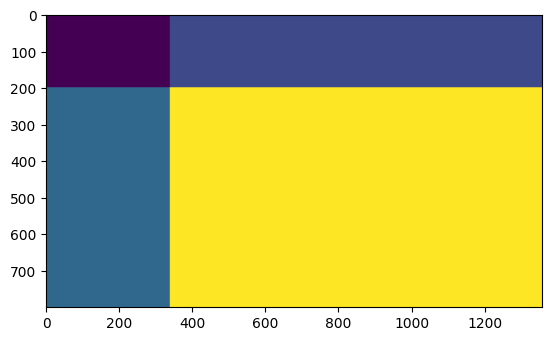

In [19]:
# Bitpacking and inserting one frame

phase = np.zeros((24, M, N), dtype=np.float32)
phase[:,:M//4,:N//4] = 0.0
phase[:,:M//4,N//4:] = 0.2
phase[:,M//4:,:N//4] = 0.3
phase[:,M//4:,N//4:] = 0.9

plt.imshow(phase[0,:,:])

frame = plm.bitpack_holograms_gpu(phase)
plm.insert_frames(frame, 0, format=1)

In [8]:
# Bitpacking and inserting one frame at a time

numHolograms = 24

phase = np.zeros((numHolograms, M, N ), dtype = np.float32)
for i in range(MAX_FRAMES):
    a = np.linspace(0, i*2 + 1, np.shape(phase)[2])[None, :]
    b = np.linspace(0, 0, np.shape(phase)[1])[:, None]
    ph = np.mod(a + b, 1)
    phase[:,:,:] = np.tile(ph[np.newaxis, :, :], (24, 1, 1))
    
    plm.bitpack_and_insert_gpu(phase, i)
    
    

In [7]:
# Bitpacking frames first and then inserting them all at once

# Sending the pointers to the bitpack_holograms_gpu_ptr function is faster than using bitpack_holograms_gpu
# This avoids creating the full RGB frame inside this function. Giving the pointers for plmctrl to act on them is faster.

numHolograms = 24

frames = np.zeros((MAX_FRAMES, 2*M, 4*2*N), dtype=np.uint8)
phase = np.zeros((numHolograms, M, N), dtype=np.float32)

for i in range(MAX_FRAMES):
    a = np.linspace(0, 0, np.shape(phase)[2])[None, :]
    b = np.linspace(0, i*2 + 1, np.shape(phase)[1])[:, None]
    ph = np.mod(a + b, 1)
    phase[:,:,:] = np.tile(ph[np.newaxis, :, :], (24, 1, 1))

    phase_ptr = phase.ctypes.data_as(ctypes.POINTER(ctypes.c_float))
    frame_i = frames[i,:,:]
    frame_ptr = frame_i.ctypes.data_as(ctypes.POINTER(ctypes.c_uint8))  
      
    plm.bitpack_holograms_gpu_ptr(phase_ptr, frame_ptr, numHolograms)
            
plm.insert_frames(frames, 0, format=1)




1

In [ ]:
# Create multiple holograms
x, y = np.meshgrid(np.linspace(-1, 1, N), np.linspace(-M/N, M/N, M))
wedge = lambda alpha, beta: alpha*x + beta*y

numHolograms = 24

frame = np.zeros((MAX_FRAMES, 2*M, 4*2*N), dtype=np.uint8) # by default, python uses row-major order.
phase = np.zeros((numHolograms, M, N), dtype=np.float32)

for j in range(MAX_FRAMES):

    print(f"Python: Generating bitpacked hologram #{j+1}")
    for i in range(numHolograms):
        alpha = 2 * (np.random.rand() - 0.5)
        beta = 2 * (np.random.rand() - 0.5)
        phase[i,:,:] = np.mod(wedge(alpha, beta), 2*np.pi) / (2*np.pi)

    phase_ptr = phase.ctypes.data_as(ctypes.POINTER(ctypes.c_float))
    frame_j = frame[j,:,:]
    frame_ptr = frame_j.ctypes.data_as(ctypes.POINTER(ctypes.c_uint8))  
      
    plm.bitpack_holograms_gpu_ptr(phase_ptr, frame_ptr, numHolograms)

plm.insert_frames(frame, 0, format=1)

Python: Generating bitpacked hologram #1
Python: Generating bitpacked hologram #2
Python: Generating bitpacked hologram #3
Python: Generating bitpacked hologram #4


1

In [7]:
plm.cleanup()